<a href="https://colab.research.google.com/github/htnphu/retail-demand-forecasting/blob/main/m5_preprocessing_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt

from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8')

import gc

import logging
import warnings

warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/Fall_2025/CPSC_5305_Intro_to_DS/data/"

In [ ]:
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype

        # --- FIX: Skip Datetime Columns ---
        if pd.api.types.is_datetime64_any_dtype(col_type):
            continue
        # -----------------------------------

        # Only process numeric columns for min/max
        if col_type != object and not isinstance(col_type, pd.CategoricalDtype):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                # This is where the error occurred previously for datetime types
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        # Handle categorical columns without min/max
        elif isinstance(col_type, pd.CategoricalDtype):
            df[col] = df[col].cat.as_unordered()  # Ensure no ordering assumption
        else:
            df[col] = df[col].astype('category')  # Convert objects to category
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Memory usage decreased from {start_mem:.2f} Mb to {end_mem:.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

In [ ]:
print("Loading and reducing memory usage for data files...")

# load the datasets and apply memory reduction
calendar = pd.read_csv(f'{DATA_PATH}calendar.csv')
calendar = reduce_mem_usage(calendar)

sell_prices = pd.read_csv(f'{DATA_PATH}sell_prices.csv')
sell_prices = reduce_mem_usage(sell_prices)

# using 'sales_train_evaluation.csv' for the full data because it's the most complete one
sales = pd.read_csv(f'{DATA_PATH}sales_train_evaluation.csv')
sales = reduce_mem_usage(sales)

print("\nInitial data loading complete.")

Loading and reducing memory usage for data files...
Memory usage decreased from 0.21 Mb to 0.19 Mb (8.7% reduction)
Memory usage decreased from 208.77 Mb to 58.80 Mb (71.8% reduction)
Memory usage decreased from 452.91 Mb to 96.30 Mb (78.7% reduction)

Initial data loading complete.


In [ ]:
print(calendar.head().to_markdown())

|    | date       |   wm_yr_wk | weekday   |   wday |   month |   year | d   |   event_name_1 |   event_type_1 |   event_name_2 |   event_type_2 |   snap_CA |   snap_TX |   snap_WI |
|---:|:-----------|-----------:|:----------|-------:|--------:|-------:|:----|---------------:|---------------:|---------------:|---------------:|----------:|----------:|----------:|
|  0 | 2011-01-29 |      11101 | Saturday  |      1 |       1 |   2011 | d_1 |            nan |            nan |            nan |            nan |         0 |         0 |         0 |
|  1 | 2011-01-30 |      11101 | Sunday    |      2 |       1 |   2011 | d_2 |            nan |            nan |            nan |            nan |         0 |         0 |         0 |
|  2 | 2011-01-31 |      11101 | Monday    |      3 |       1 |   2011 | d_3 |            nan |            nan |            nan |            nan |         0 |         0 |         0 |
|  3 | 2011-02-01 |      11101 | Tuesday   |      4 |       2 |   2011 | d_4 |       

In [ ]:
calendar['date'] = pd.to_datetime(calendar['date'])

In [ ]:
print(calendar.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1969 non-null   datetime64[ns]
 1   wm_yr_wk      1969 non-null   int16         
 2   weekday       1969 non-null   category      
 3   wday          1969 non-null   int8          
 4   month         1969 non-null   int8          
 5   year          1969 non-null   int16         
 6   d             1969 non-null   category      
 7   event_name_1  162 non-null    category      
 8   event_type_1  162 non-null    category      
 9   event_name_2  5 non-null      category      
 10  event_type_2  5 non-null      category      
 11  snap_CA       1969 non-null   int8          
 12  snap_TX       1969 non-null   int8          
 13  snap_WI       1969 non-null   int8          
dtypes: category(6), datetime64[ns](1), int16(2), int8(5)
memory usage: 128.3 KB
None


In [ ]:
print(calendar.shape)

(1969, 14)


In [ ]:
print(calendar.isnull().sum().to_markdown())

|              |    0 |
|:-------------|-----:|
| date         |    0 |
| wm_yr_wk     |    0 |
| weekday      |    0 |
| wday         |    0 |
| month        |    0 |
| year         |    0 |
| d            |    0 |
| event_name_1 | 1807 |
| event_type_1 | 1807 |
| event_name_2 | 1964 |
| event_type_2 | 1964 |
| snap_CA      |    0 |
| snap_TX      |    0 |
| snap_WI      |    0 |


In [ ]:
# Data cleaning & transformation for calendar

# fill missing event values
event_cols = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']

# convert to object, fill, then convert to category, this handles potential Categorical dtype errors and cleans the NaNs.
calendar[event_cols] = calendar[event_cols].astype('object')
calendar[event_cols] = calendar[event_cols].fillna('No event')
calendar[event_cols] = calendar[event_cols].astype('category')

calendar['date'] = pd.to_datetime(calendar['date'])

# verify missing values (should be all 0 now)
print("Missing values in calendar after cleaning:")
print(calendar.isnull().sum().to_markdown())

# data reduction: convert categorical columns to the category dtype
for col in calendar.columns:
    if calendar[col].dtype == 'object':
        calendar[col] = calendar[col].astype('category')

print("\nCalendar data cleaned and transformed.")

print(calendar.head().to_markdown())

Missing values in calendar after cleaning:
|              |   0 |
|:-------------|----:|
| date         |   0 |
| wm_yr_wk     |   0 |
| weekday      |   0 |
| wday         |   0 |
| month        |   0 |
| year         |   0 |
| d            |   0 |
| event_name_1 |   0 |
| event_type_1 |   0 |
| event_name_2 |   0 |
| event_type_2 |   0 |
| snap_CA      |   0 |
| snap_TX      |   0 |
| snap_WI      |   0 |

Calendar data cleaned and transformed.
|    | date                |   wm_yr_wk | weekday   |   wday |   month |   year | d   | event_name_1   | event_type_1   | event_name_2   | event_type_2   |   snap_CA |   snap_TX |   snap_WI |
|---:|:--------------------|-----------:|:----------|-------:|--------:|-------:|:----|:---------------|:---------------|:---------------|:---------------|----------:|----------:|----------:|
|  0 | 2011-01-29 00:00:00 |      11101 | Saturday  |      1 |       1 |   2011 | d_1 | No event       | No event       | No event       | No event       |         0

In [ ]:
# calendar features
calendar['month'] = calendar['date'].dt.month
calendar['quarter'] = calendar['date'].dt.quarter
calendar['week'] = calendar['date'].dt.isocalendar().week
calendar['day_of_week'] = calendar['date'].dt.dayofweek
calendar['day_of_month'] = calendar['date'].dt.day
calendar['day_of_year'] = calendar['date'].dt.dayofyear
calendar['weekend'] = calendar['day_of_week'].isin([5, 6]).astype(int)
print(f"Calendar shape: {calendar.shape}")
calendar.head()

Calendar shape: (1969, 20)


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,quarter,week,day_of_week,day_of_month,day_of_year,weekend
0,2011-01-29,11101,Saturday,1,1,2011,d_1,No event,No event,No event,No event,0,0,0,1,4,5,29,29,1
1,2011-01-30,11101,Sunday,2,1,2011,d_2,No event,No event,No event,No event,0,0,0,1,4,6,30,30,1
2,2011-01-31,11101,Monday,3,1,2011,d_3,No event,No event,No event,No event,0,0,0,1,5,0,31,31,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,No event,No event,No event,No event,1,1,0,1,5,1,1,32,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,No event,No event,No event,No event,1,0,1,1,5,2,2,33,0


## Sales - sales_train_evaluation.csv

In [ ]:
print(sales.head().to_markdown())

|    | id                            | item_id       | dept_id   | cat_id   | store_id   | state_id   |   d_1 |   d_2 |   d_3 |   d_4 |   d_5 |   d_6 |   d_7 |   d_8 |   d_9 |   d_10 |   d_11 |   d_12 |   d_13 |   d_14 |   d_15 |   d_16 |   d_17 |   d_18 |   d_19 |   d_20 |   d_21 |   d_22 |   d_23 |   d_24 |   d_25 |   d_26 |   d_27 |   d_28 |   d_29 |   d_30 |   d_31 |   d_32 |   d_33 |   d_34 |   d_35 |   d_36 |   d_37 |   d_38 |   d_39 |   d_40 |   d_41 |   d_42 |   d_43 |   d_44 |   d_45 |   d_46 |   d_47 |   d_48 |   d_49 |   d_50 |   d_51 |   d_52 |   d_53 |   d_54 |   d_55 |   d_56 |   d_57 |   d_58 |   d_59 |   d_60 |   d_61 |   d_62 |   d_63 |   d_64 |   d_65 |   d_66 |   d_67 |   d_68 |   d_69 |   d_70 |   d_71 |   d_72 |   d_73 |   d_74 |   d_75 |   d_76 |   d_77 |   d_78 |   d_79 |   d_80 |   d_81 |   d_82 |   d_83 |   d_84 |   d_85 |   d_86 |   d_87 |   d_88 |   d_89 |   d_90 |   d_91 |   d_92 |   d_93 |   d_94 |   d_95 |   d_96 |   d_97 |   d_98 |   d_99 |   d_100 |   d_

In [ ]:
print(sales.isnull().sum())

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1937      0
d_1938      0
d_1939      0
d_1940      0
d_1941      0
Length: 1947, dtype: int64


In [ ]:
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: category(6), int16(1317), int8(624)
memory usage: 96.3 MB
None


In [ ]:
print(sales.shape)

(30490, 1947)


In [ ]:
# show only columns with missing (NaN) values
sales.isnull().sum()[sales.isnull().sum() > 0]

,0


In [ ]:
# Data transformation for 'sales' (Melting to Long Format)

# identify the columns to keep as identifiers
id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

# identify the sale columns (d_1 to d_1941)
sales_cols = [col for col in sales.columns if col.startswith('d_')]

print("Melting sales data...")

# melt the df
sales_melted = sales.melt(
    id_vars=id_vars,
    value_vars=sales_cols,
    var_name='d',  # new column for the day ID (d_1, d_2, etc.)
    value_name='sales' # new column for the actual sales volume
)

sales_melted = reduce_mem_usage(sales_melted)


print("Sales data melted and memory reclaimed.")
print(f"Melted sales shape: {sales_melted.shape}")

Melting sales data...
Memory usage decreased from 1017.24 Mb to 678.68 Mb (33.3% reduction)
Sales data melted and memory reclaimed.
Melted sales shape: (59181090, 8)


In [ ]:
print(sales_melted.head().to_markdown())

|    | id                            | item_id       | dept_id   | cat_id   | store_id   | state_id   | d   |   sales |
|---:|:------------------------------|:--------------|:----------|:---------|:-----------|:-----------|:----|--------:|
|  0 | HOBBIES_1_001_CA_1_evaluation | HOBBIES_1_001 | HOBBIES_1 | HOBBIES  | CA_1       | CA         | d_1 |       0 |
|  1 | HOBBIES_1_002_CA_1_evaluation | HOBBIES_1_002 | HOBBIES_1 | HOBBIES  | CA_1       | CA         | d_1 |       0 |
|  2 | HOBBIES_1_003_CA_1_evaluation | HOBBIES_1_003 | HOBBIES_1 | HOBBIES  | CA_1       | CA         | d_1 |       0 |
|  3 | HOBBIES_1_004_CA_1_evaluation | HOBBIES_1_004 | HOBBIES_1 | HOBBIES  | CA_1       | CA         | d_1 |       0 |
|  4 | HOBBIES_1_005_CA_1_evaluation | HOBBIES_1_005 | HOBBIES_1 | HOBBIES  | CA_1       | CA         | d_1 |       0 |


In [ ]:
print(sales_melted.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 8 columns):
 #   Column    Dtype   
---  ------    -----   
 0   id        category
 1   item_id   category
 2   dept_id   category
 3   cat_id    category
 4   store_id  category
 5   state_id  category
 6   d         category
 7   sales     int16   
dtypes: category(7), int16(1)
memory usage: 678.7 MB
None


In [ ]:
print(sales_melted.isnull().sum())

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
state_id    0
d           0
sales       0
dtype: int64


In [ ]:
print(sales_melted['sales'].describe())

count    5.918109e+07
mean     1.130888e+00
std      3.870038e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      7.630000e+02
Name: sales, dtype: float64


## Sell prices

In [ ]:
print(sell_prices.head().to_markdown())

|    | store_id   | item_id       |   wm_yr_wk |   sell_price |
|---:|:-----------|:--------------|-----------:|-------------:|
|  0 | CA_1       | HOBBIES_1_001 |      11325 |         9.58 |
|  1 | CA_1       | HOBBIES_1_001 |      11326 |         9.58 |
|  2 | CA_1       | HOBBIES_1_001 |      11327 |         8.26 |
|  3 | CA_1       | HOBBIES_1_001 |      11328 |         8.26 |
|  4 | CA_1       | HOBBIES_1_001 |      11329 |         8.26 |


In [ ]:
print(sell_prices.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype   
---  ------      -----   
 0   store_id    category
 1   item_id     category
 2   wm_yr_wk    int16   
 3   sell_price  float32 
dtypes: category(2), float32(1), int16(1)
memory usage: 58.8 MB
None


In [ ]:
print(sell_prices.shape)

(6841121, 4)


In [ ]:
print(sell_prices.isnull().sum())

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64


In [ ]:
print(sell_prices['sell_price'].describe())

count    6.841121e+06
mean     4.410955e+00
std      3.390167e+00
min      1.000000e-02
25%      2.180000e+00
50%      3.470000e+00
75%      5.840000e+00
max      1.073200e+02
Name: sell_price, dtype: float64


## Final df

In [ ]:
# merge with calendar
sales_with_cal_and_wm = sales_melted.merge(
    calendar[['d', 'wm_yr_wk']],
    on='d',
    how='left'
)

# merge with sell_prices
df = sales_with_cal_and_wm.merge(
    sell_prices,
    on=['store_id', 'item_id', 'wm_yr_wk'],
    how='left'
)

print(df.head().to_markdown())

|    | id                            | item_id       | dept_id   | cat_id   | store_id   | state_id   | d   |   sales |   wm_yr_wk |   sell_price |
|---:|:------------------------------|:--------------|:----------|:---------|:-----------|:-----------|:----|--------:|-----------:|-------------:|
|  0 | HOBBIES_1_001_CA_1_evaluation | HOBBIES_1_001 | HOBBIES_1 | HOBBIES  | CA_1       | CA         | d_1 |       0 |      11101 |          nan |
|  1 | HOBBIES_1_002_CA_1_evaluation | HOBBIES_1_002 | HOBBIES_1 | HOBBIES  | CA_1       | CA         | d_1 |       0 |      11101 |          nan |
|  2 | HOBBIES_1_003_CA_1_evaluation | HOBBIES_1_003 | HOBBIES_1 | HOBBIES  | CA_1       | CA         | d_1 |       0 |      11101 |          nan |
|  3 | HOBBIES_1_004_CA_1_evaluation | HOBBIES_1_004 | HOBBIES_1 | HOBBIES  | CA_1       | CA         | d_1 |       0 |      11101 |          nan |
|  4 | HOBBIES_1_005_CA_1_evaluation | HOBBIES_1_005 | HOBBIES_1 | HOBBIES  | CA_1       | CA         | d_1 |   

In [ ]:
# merge calendar features again (since wm_yr_wk merge was intermediary)
df = df.merge(
    calendar[['d', 'date', 'weekday', 'wday', 'month', 'year', 'snap_CA', 'snap_TX', 'snap_WI', 'day_of_week', 'day_of_month', 'day_of_year', 'weekend', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']],
    on='d',
    how='left',
    suffixes=('_sales', '_cal')
)


In [ ]:
print(df.head().to_markdown())

|    | id                            | item_id       | dept_id   | cat_id   | store_id   | state_id   | d   |   sales |   wm_yr_wk |   sell_price | date                | weekday   |   wday |   month |   year |   snap_CA |   snap_TX |   snap_WI |   day_of_week |   day_of_month |   day_of_year |   weekend | event_name_1   | event_type_1   | event_name_2   | event_type_2   |
|---:|:------------------------------|:--------------|:----------|:---------|:-----------|:-----------|:----|--------:|-----------:|-------------:|:--------------------|:----------|-------:|--------:|-------:|----------:|----------:|----------:|--------------:|---------------:|--------------:|----------:|:---------------|:---------------|:---------------|:---------------|
|  0 | HOBBIES_1_001_CA_1_evaluation | HOBBIES_1_001 | HOBBIES_1 | HOBBIES  | CA_1       | CA         | d_1 |       0 |      11101 |          nan | 2011-01-29 00:00:00 | Saturday  |      1 |       1 |   2011 |         0 |         0 |         0 |     

In [ ]:
print(df['sell_price'].isnull().sum())

12299413


In [ ]:
print(df['event_name_1'].isnull().sum())

0


In [ ]:
print(df.isna().sum())

id                     0
item_id                0
dept_id                0
cat_id                 0
store_id               0
state_id               0
d                      0
sales                  0
wm_yr_wk               0
sell_price      12299413
date                   0
weekday                0
wday                   0
month                  0
year                   0
snap_CA                0
snap_TX                0
snap_WI                0
day_of_week            0
day_of_month           0
day_of_year            0
weekend                0
event_name_1           0
event_type_1           0
event_name_2           0
event_type_2           0
dtype: int64


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 26 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   d             object        
 7   sales         int16         
 8   wm_yr_wk      int16         
 9   sell_price    float32       
 10  date          datetime64[ns]
 11  weekday       category      
 12  wday          int8          
 13  month         int32         
 14  year          int16         
 15  snap_CA       int8          
 16  snap_TX       int8          
 17  snap_WI       int8          
 18  day_of_week   int32         
 19  day_of_month  int32         
 20  day_of_year   int32         
 21  weekend       int64         
 22  event_name_1  category      
 23  event_type_1  category      
 

## Data preprocessing and feature engineering

sell_price has missing values. These represent days when the product was not sold (likely not in stock or not yet released). A common strategy is to forward-fill the prices, assuming the price remains the same from the last day it was sold.

In [ ]:
# sort by id and date to ensure correct forward fill
df.sort_values(by=['id', 'date'], inplace=True)

# group by 'id' and forward-fill missing prices
# this ensures we don't bleed prices from one item-store to another
df['sell_price'] = df.groupby('id')['sell_price'].ffill()

# for any remaining NaNs at the beginning (before first sale), we can backfill
df['sell_price'] = df.groupby('id')['sell_price'].bfill()

# NOTE:
# When the code runs df.groupby('id')['sell_price'].ffill(),
# it is grouping by that entire unique ID -> so, it's already creating
# a separate group for each item at each specific store.
# For example, it will process:
# HOBBIES_1_001_CA_1 as one group.
# HOBBIES_1_001_CA_2 as a completely separate group.
# HOBBIES_1_001_TX_1 as yet another separate group.
# ....
# -> SO: no worry about filling same price for items between states

# Because of this, the ffill() (forward fill) and bfill() (backward fill)
# operations only use prices from within that same item's history at that same store.
# It will not use a price from store CA_1 to fill a missing value for the same item in store TX_1.

print("Missing values after processing:")
print(df.isnull().sum())

Missing values after processing:
id              0
item_id         0
dept_id         0
cat_id          0
store_id        0
state_id        0
d               0
sales           0
wm_yr_wk        0
sell_price      0
date            0
weekday         0
wday            0
month           0
year            0
snap_CA         0
snap_TX         0
snap_WI         0
day_of_week     0
day_of_month    0
day_of_year     0
weekend         0
event_name_1    0
event_type_1    0
event_name_2    0
event_type_2    0
dtype: int64


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 59181090 entries, 1612 to 59179652
Data columns (total 26 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   d             object        
 7   sales         int16         
 8   wm_yr_wk      int16         
 9   sell_price    float32       
 10  date          datetime64[ns]
 11  weekday       category      
 12  wday          int8          
 13  month         int32         
 14  year          int16         
 15  snap_CA       int8          
 16  snap_TX       int8          
 17  snap_WI       int8          
 18  day_of_week   int32         
 19  day_of_month  int32         
 20  day_of_year   int32         
 21  weekend       int64         
 22  event_name_1  category      
 23  event_type_1  category      
 24

In [ ]:
print(df.head().to_markdown())

|        | id                          | item_id     | dept_id   | cat_id   | store_id   | state_id   | d   |   sales |   wm_yr_wk |   sell_price | date                | weekday   |   wday |   month |   year |   snap_CA |   snap_TX |   snap_WI |   day_of_week |   day_of_month |   day_of_year |   weekend | event_name_1   | event_type_1   | event_name_2   | event_type_2   |
|-------:|:----------------------------|:------------|:----------|:---------|:-----------|:-----------|:----|--------:|-----------:|-------------:|:--------------------|:----------|-------:|--------:|-------:|----------:|----------:|----------:|--------------:|---------------:|--------------:|----------:|:---------------|:---------------|:---------------|:---------------|
|   1612 | FOODS_1_001_CA_1_evaluation | FOODS_1_001 | FOODS_1   | FOODS    | CA_1       | CA         | d_1 |       3 |      11101 |            2 | 2011-01-29 00:00:00 | Saturday  |      1 |       1 |   2011 |         0 |         0 |         0 |     

1. price_mean (Average Price per Item/Store) -> calculates the average price for each specific item at each specific store over the entire time period.

Why it's needed: A price of $2.99 is meaningless without context. Is that cheap or expensive? For a loaf of bread, it might be normal. For a single banana, it would be extremely expensive. For a bottle of wine, it would be very cheap. This "normal" price is what the price_mean establishes for each individual item.

2. price_relative_to_mean (Current Price vs. Average Price) ->  calculates the ratio of the current sell_price to the price_mean (e.g., sell_price / price_mean).

Why it's needed: This is a good feature that captures promotions and discounts.

If this value is < 1.0, it means the item is on sale (cheaper than its average). This is a strong signal that might lead to a surge in sales.

If this value is > 1.0, it means the item is priced higher than usual, which might decrease sales.

If this value is ~1.0, it's at its normal price.

A machine learning model can learn this relationship: "When price_relative_to_mean is low, sales are high." This is much more informative than just "the price is $2.49."

3. price_change_lag (Price Change from Previous Day) -> calculates the difference between the price on day D and the price on day D-1.

Why it's needed: This feature captures the "shock" or "event" of a price change.

A large negative value (example: -1.00) indicates the start of a promotion. This is a very strong signal that often causes a big, immediate spike in sales as customers react to the new low price.

A large positive value indicates the end of a promotion. This can cause a sudden drop in sales.

A value of 0 means the price is stable, which is also important information (example: a sale is ongoing, or it's just the normal price).

Summary
While could just give the model the sell_price, it would have to learn the concept of a "normal" price and a "sale" price for all items individually. By engineering these features, we are explicitly giving the model this information, making its job much easier and leading to a more accurate forecast. (I think :)

In [ ]:
# mean price per item-store
df['price_mean'] = df.groupby(['item_id', 'store_id'])['sell_price'].transform('mean')

# relative price feature
df['price_relative_to_mean'] = df['sell_price'] / df['price_mean']

# price change from previous day (sorted first for accuracy)
df = df.sort_values(['id', 'date'])
df['price_change_lag'] = df.groupby('id')['sell_price'].diff().fillna(0)

print(df.head().to_markdown())

|        | id                          | item_id     | dept_id   | cat_id   | store_id   | state_id   | d   |   sales |   wm_yr_wk |   sell_price | date                | weekday   |   wday |   month |   year |   snap_CA |   snap_TX |   snap_WI |   day_of_week |   day_of_month |   day_of_year |   weekend | event_name_1   | event_type_1   | event_name_2   | event_type_2   |   price_mean |   price_relative_to_mean |   price_change_lag |
|-------:|:----------------------------|:------------|:----------|:---------|:-----------|:-----------|:----|--------:|-----------:|-------------:|:--------------------|:----------|-------:|--------:|-------:|----------:|----------:|----------:|--------------:|---------------:|--------------:|----------:|:---------------|:---------------|:---------------|:---------------|-------------:|-------------------------:|-------------------:|
|   1612 | FOODS_1_001_CA_1_evaluation | FOODS_1_001 | FOODS_1   | FOODS    | CA_1       | CA         | d_1 |       3 |     

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 59181090 entries, 1612 to 59179652
Data columns (total 29 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   id                      category      
 1   item_id                 category      
 2   dept_id                 category      
 3   cat_id                  category      
 4   store_id                category      
 5   state_id                category      
 6   d                       object        
 7   sales                   int16         
 8   wm_yr_wk                int16         
 9   sell_price              float32       
 10  date                    datetime64[ns]
 11  weekday                 category      
 12  wday                    int8          
 13  month                   int32         
 14  year                    int16         
 15  snap_CA                 int8          
 16  snap_TX                 int8          
 17  snap_WI                 int8          
 18  da

In [ ]:
print(df.shape)

(59181090, 29)


In [ ]:
df.to_csv(DATA_PATH + "m5_processed.csv", index=False)

# EDA

Percentage of days with zero sales: 68.00%


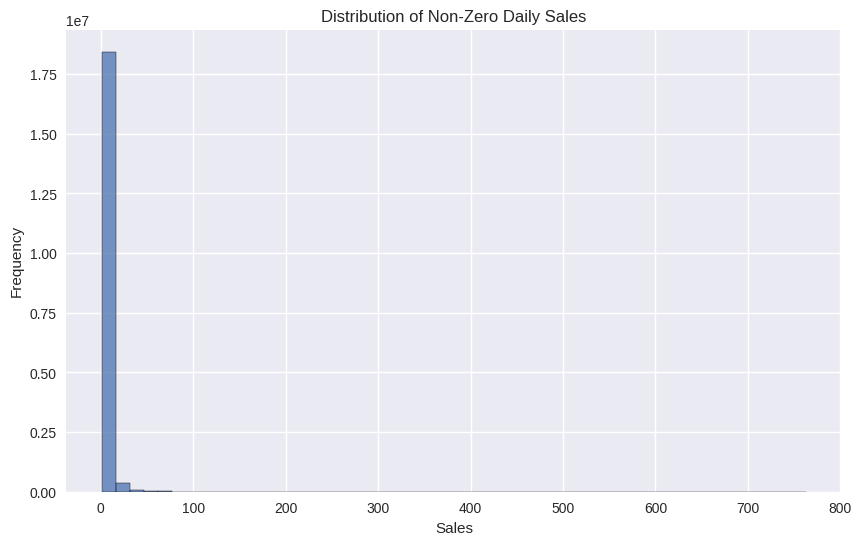

In [ ]:
# Calculate zero-sales percentage
zero_sales_pct = (df['sales'] == 0).mean() * 100
print(f'Percentage of days with zero sales: {zero_sales_pct:.2f}%')

# Plot histogram of sales (excluding zeros for better visibility of non-zero sales)
plt.figure(figsize=(10, 6))
sns.histplot(df[df['sales'] > 0]['sales'], bins=50)
plt.title('Distribution of Non-Zero Daily Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

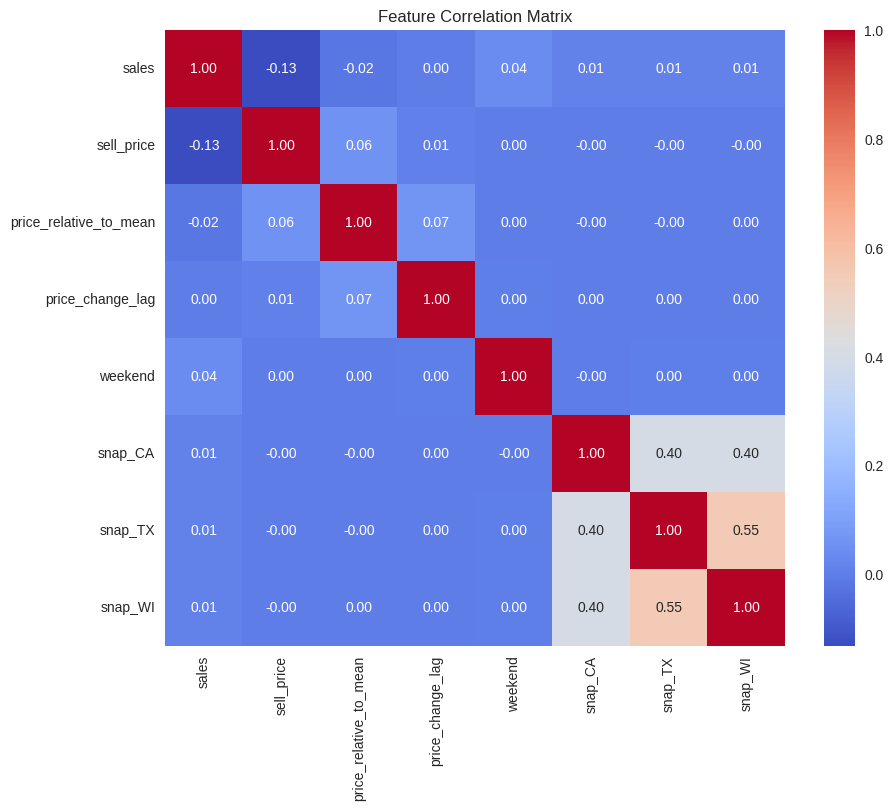

In [ ]:
# relevant columns for correlation
corr_cols = ['sales', 'sell_price', 'price_relative_to_mean', 'price_change_lag', 'weekend', 'snap_CA', 'snap_TX', 'snap_WI']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

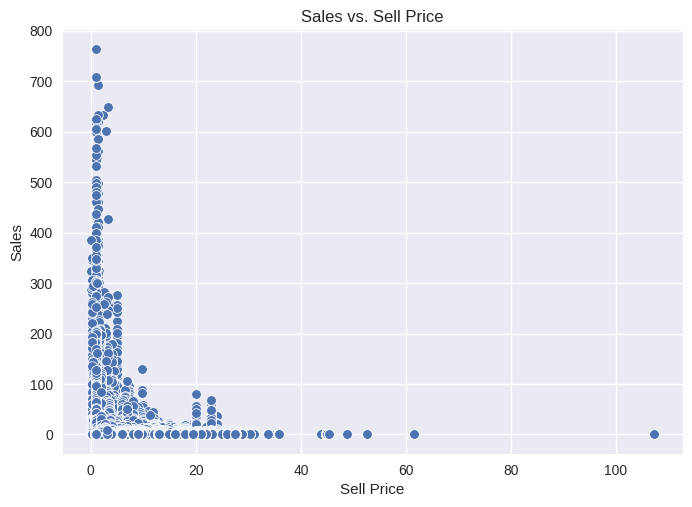

In [ ]:
sns.scatterplot(data=df, x='sell_price', y='sales')
plt.title('Sales vs. Sell Price')
plt.xlabel('Sell Price')
plt.ylabel('Sales')

plt.show()

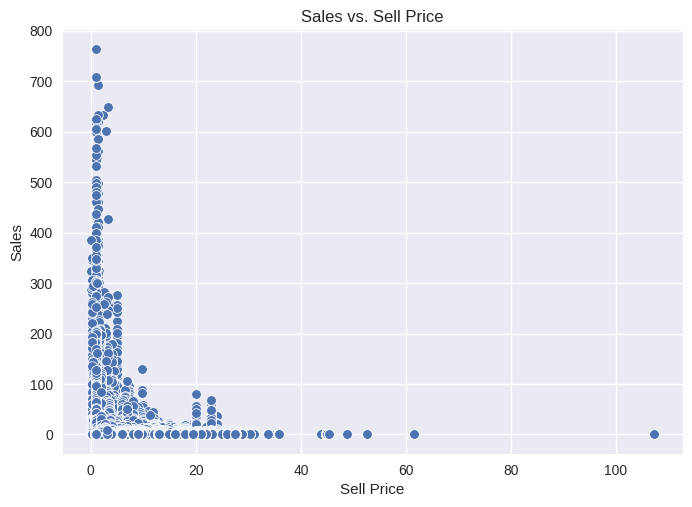

In [ ]:
sns.scatterplot(data=df, x='sell_price', y='sales')
plt.title('Sales vs. Sell Price')
plt.xlabel('Sell Price')
plt.ylabel('Sales')

plt.show()

In [ ]:
gc.collect()

18268

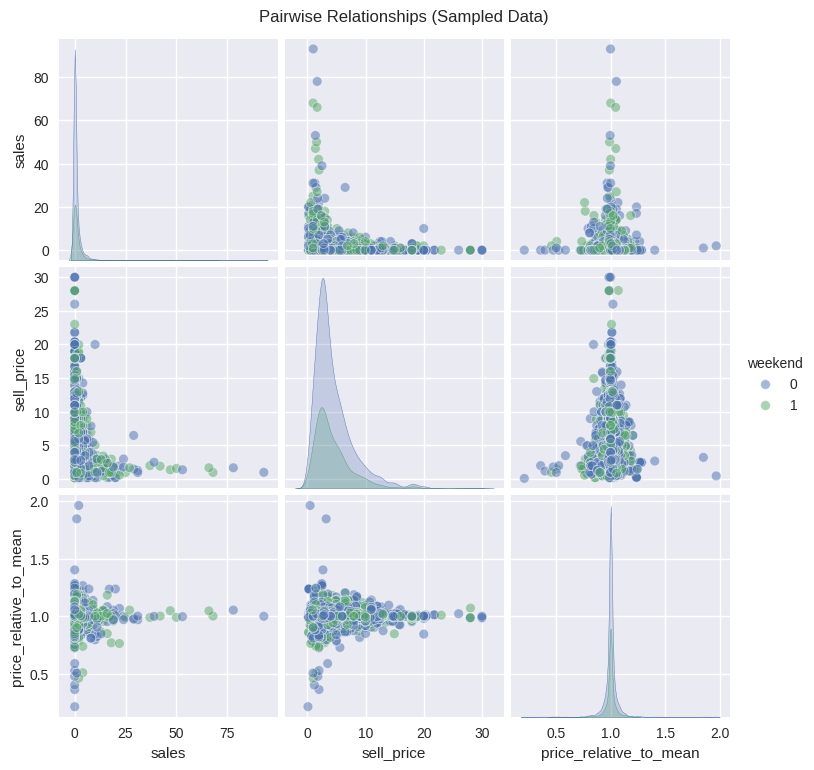

In [ ]:
# take a sample
df_sample = df.sample(n=5000, random_state=42)

# pairwise relationships
sns.pairplot(df_sample[['sales', 'sell_price', 'price_relative_to_mean', 'weekend']],
             hue='weekend',
             plot_kws={'alpha': 0.5})
plt.suptitle('Pairwise Relationships (Sampled Data)', y=1.02)
plt.show()

In [ ]:
# aggregate sales by store
store_sales = df.groupby('store_id')['sales'].sum().reset_index()

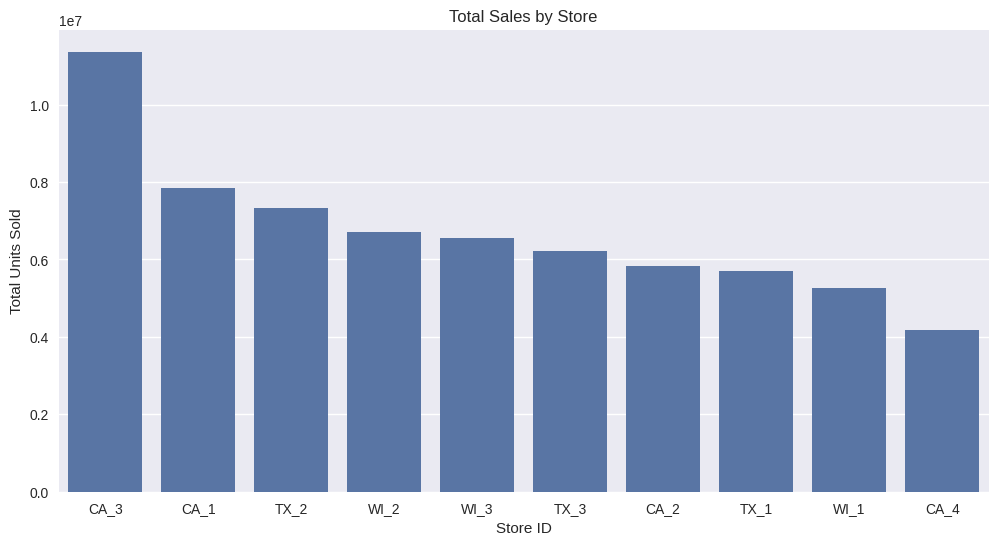

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='store_id', y='sales', data=store_sales, order=store_sales.sort_values('sales', ascending=False)['store_id'])
plt.title('Total Sales by Store')
plt.xlabel('Store ID')
plt.ylabel('Total Units Sold')
plt.show()

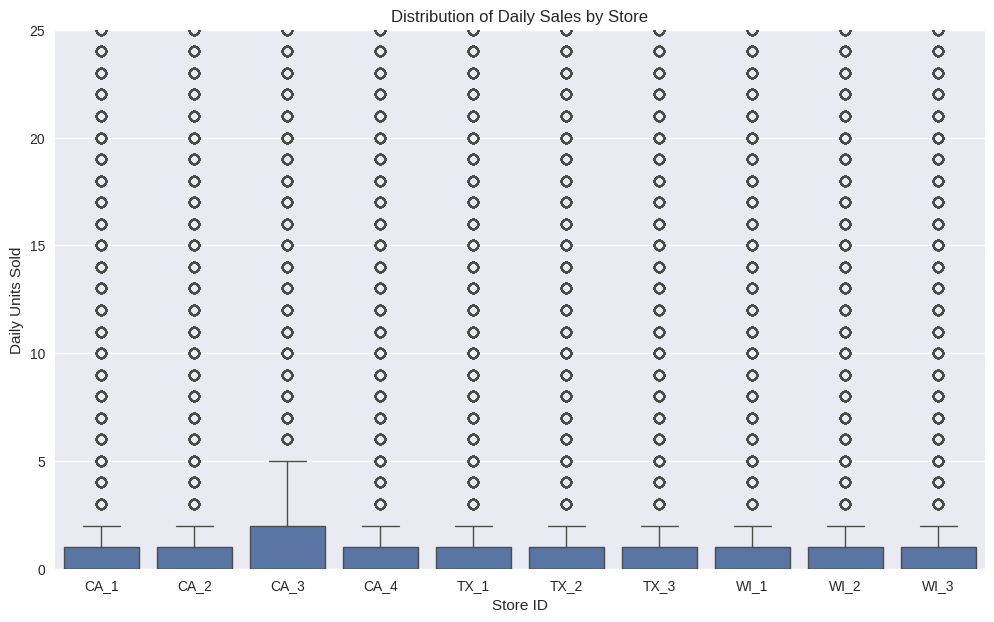

In [ ]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='store_id', y='sales', data=df)
plt.ylim(0, 25)
plt.title('Distribution of Daily Sales by Store')
plt.xlabel('Store ID')
plt.ylabel('Daily Units Sold')
plt.show()

In [ ]:
gc.collect()

3751

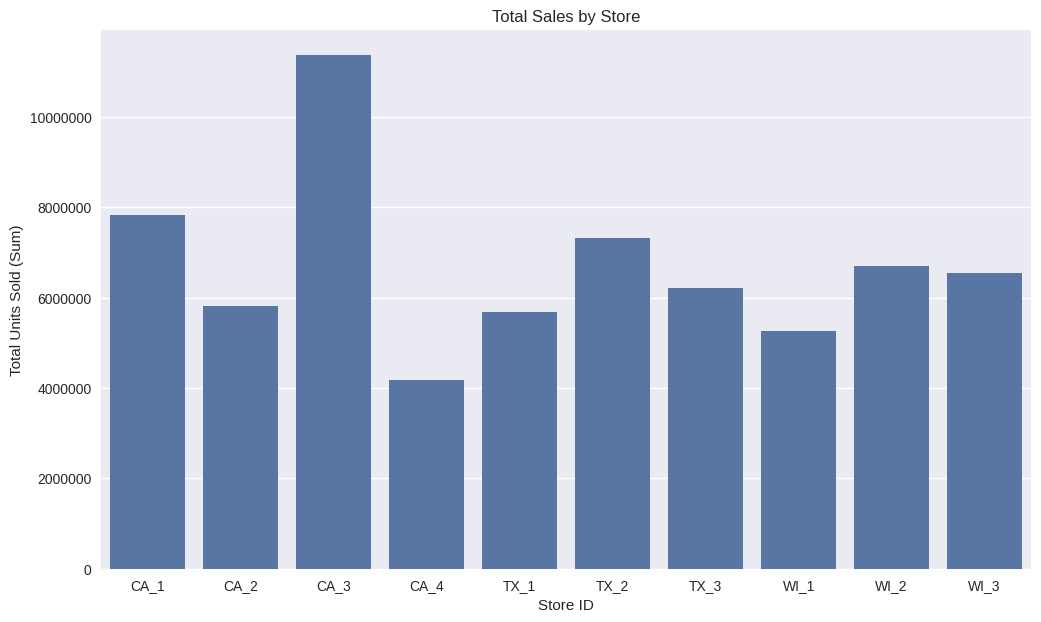

In [ ]:
plt.figure(figsize=(12, 7))

total_sales = df.groupby('store_id')['sales'].sum().reset_index()

sns.barplot(x='store_id', y='sales', data=total_sales)

plt.ticklabel_format(style='plain', axis='y')
plt.title('Total Sales by Store')
plt.xlabel('Store ID')
plt.ylabel('Total Units Sold (Sum)')

plt.savefig('total_sales_by_store.png')

In [ ]:
gc.collect()

43643

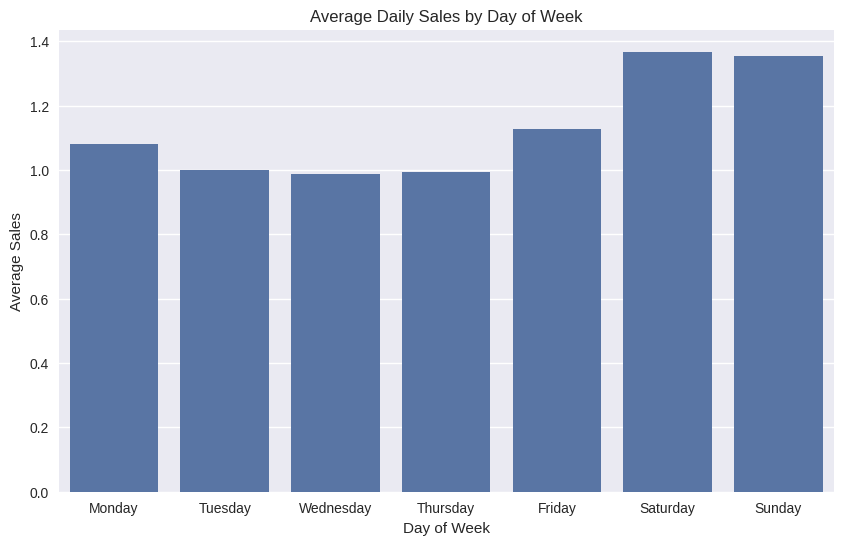

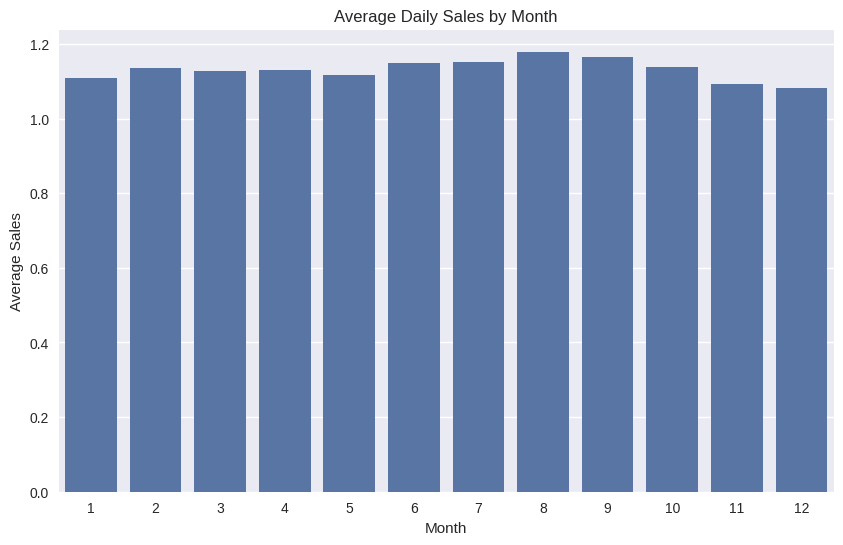

In [ ]:
# Aggregate sales by day of the week
weekday_sales = df.groupby('weekday')['sales'].mean().reset_index()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sales['weekday'] = pd.Categorical(weekday_sales['weekday'], categories=weekday_order, ordered=True)
weekday_sales = weekday_sales.sort_values('weekday')

plt.figure(figsize=(10, 6))
sns.barplot(x='weekday', y='sales', data=weekday_sales)
plt.title('Average Daily Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.savefig('Average_Daily_Sales_by_Day_of_Week.png')

month_sales = df.groupby('month')['sales'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='sales', data=month_sales)
plt.title('Average Daily Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.savefig('Average_Daily_Sales_by_Month.png')


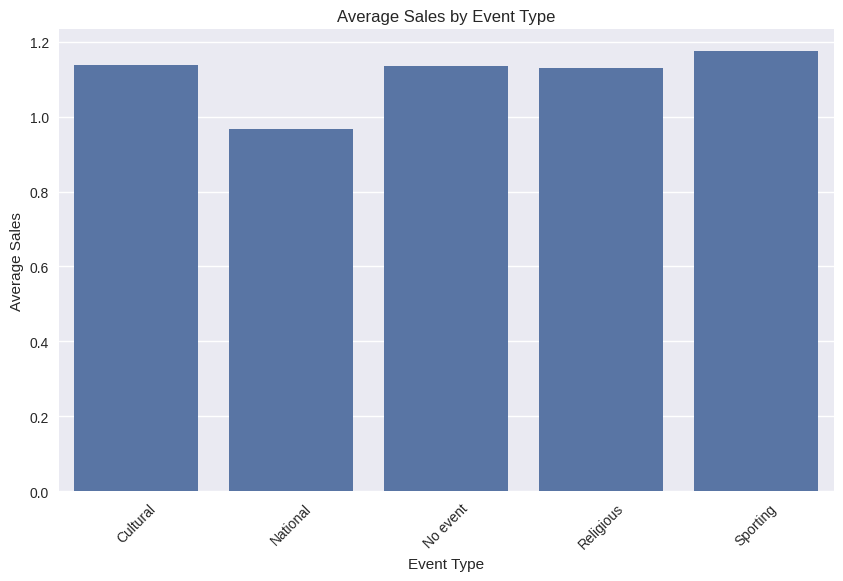

In [ ]:
# Aggregate sales by event type
event_sales = df.groupby('event_type_1')['sales'].mean().reset_index().sort_values('sales', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='event_type_1', y='sales', data=event_sales)
plt.title('Average Sales by Event Type')
plt.xlabel('Event Type')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.savefig('Average_Sales_by_Event_Type.png')

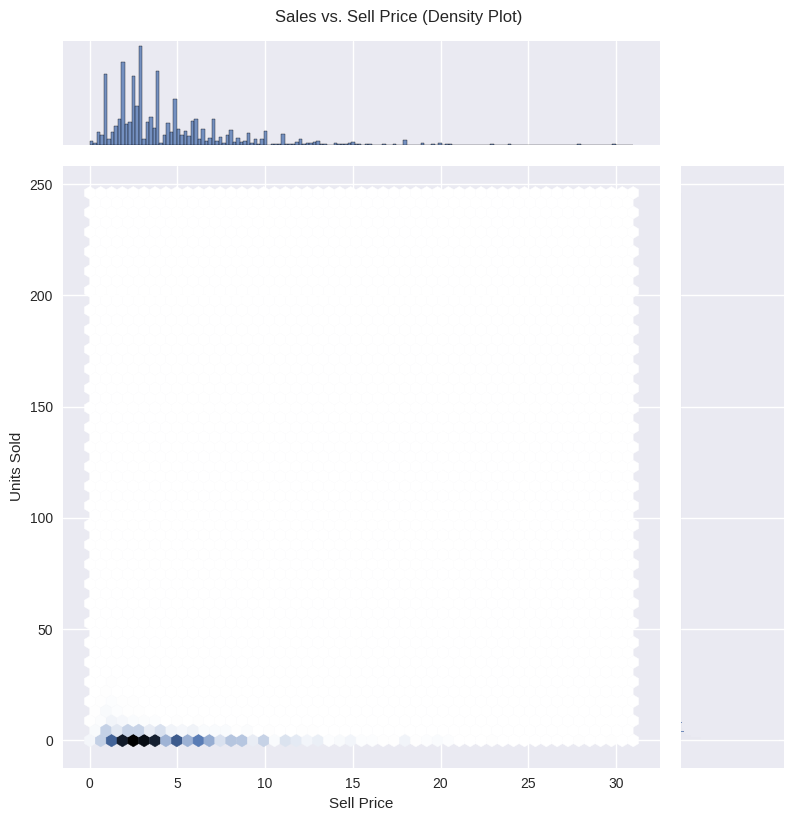

In [ ]:
# Using a hexbin plot for better visualization of density
sns.jointplot(x='sell_price', y='sales', data=df.sample(50000), kind='hex', height=8)
plt.suptitle('Sales vs. Sell Price (Density Plot)', y=1.02)
plt.xlabel('Sell Price')
plt.ylabel('Units Sold')
plt.savefig('Sales_vs_Sell_Price_(Density_Plot).png')

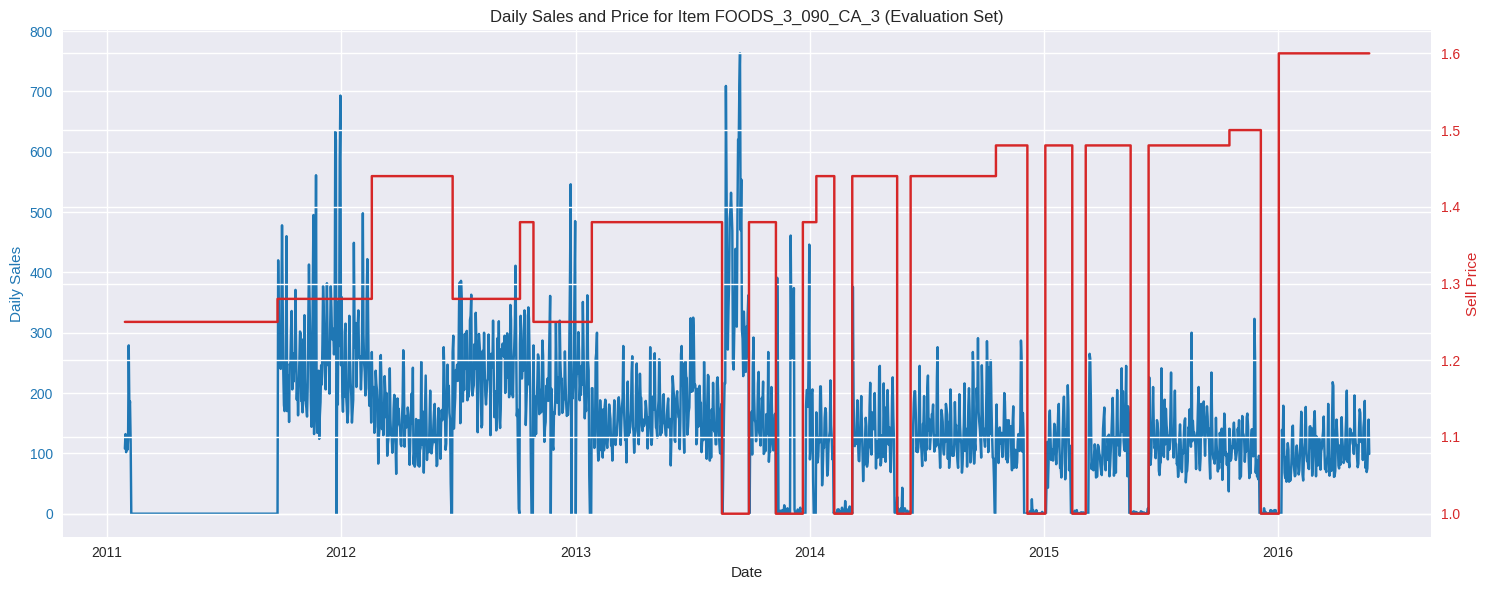

In [ ]:
item_df = df[df['id'] == 'FOODS_3_090_CA_3_evaluation'].copy()

item_df = item_df.sort_values('date')

fig, ax1 = plt.subplots(figsize=(15, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Sales', color=color)
ax1.plot(item_df['date'], item_df['sales'], color=color, label='Sales')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Sell Price', color=color)
ax2.step(item_df['date'], item_df['sell_price'], color=color, label='Price', where='post')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Daily Sales and Price for Item FOODS_3_090_CA_3 (Evaluation Set)')
fig.tight_layout()
plt.savefig('Daily_Sales_and_Price_for_Item_FOODS_3_090_CA_3_(Evaluation_Set).png')

In [ ]:
gc.collect()

136